In [31]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import scipy 
import statsmodels.api as sm
from statsmodels.stats.meta_analysis import (
    combine_effects
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from matplotlib.gridspec import GridSpec
from plotnine import ggplot, aes, geom_density


from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# downloading from kaggle.com/c/sentiment-analysis-on-movie-reviews
# there are two files, train.tsv.zip and test.tsv.zip
# we write to the current directory with './'
api.competition_download_file('titanic',
                              'gender_submission.csv', path='./data/')
api.competition_download_file('titanic',
                              'train.csv', path='./data/')
api.competition_download_file('titanic',
                              'test.csv', path='./data/')

df_train = pd.read_csv('data/train.csv')
df_train["Family"] = df_train["SibSp"] + df_train["Parch"]
X = df_train.drop(['Survived', 'Name', 'PassengerId', "Cabin", "Ticket", "SibSp", "Parch"], axis = 1)
y = df_train['Survived']

X = X.apply(preprocessing.LabelEncoder().fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#df_test = pd.read_csv('data/test.csv')
#df_test = df_test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis = 1)

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


## Decision Tree

In [32]:
tree = DecisionTreeClassifier(max_depth = 5, random_state = 0)
tree_fit = tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

dt_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])

## Random Forest


In [33]:
rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators = 100)
rf_fit = rf.fit(X_train, y_train)

rf.predict_proba(X_test)

rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

## Logistic Regression



In [34]:
logit_fit = sm.Logit(y_train, X_train).fit()

print(logit_fit.summary())

y_pred = logit_fit.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, y_pred)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_pred)


Optimization terminated successfully.
         Current function value: 0.472853
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            5
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                  0.2897
Time:                        11:40:09   Log-Likelihood:                -336.67
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 2.823e-57
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass         0.1368      0.122      1.120      0.263      -0.103       0.376
Sex           -2.4481      0.

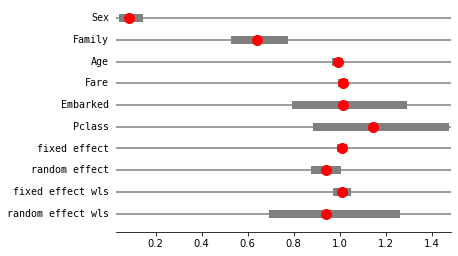

In [35]:
cov = logit_fit.cov_params()
var_effect = np.diag(cov)
mean_effect = logit_fit.params

estimates = pd.concat([pd.DataFrame(mean_effect, columns = ['mean']).reset_index(drop=True),
    pd.DataFrame(var_effect, columns = ['var']).reset_index(drop=True),
    pd.DataFrame(X_train.columns, columns = ['param']).reset_index(drop=True)], axis = 1).sort_values(by=['mean'])

results = combine_effects(estimates['mean'].to_numpy(), estimates['var'].to_numpy(), method_re="chi2", row_names=estimates['param'].to_numpy())
#print(np.exp(logit_fit.params))
fig = results.plot_forest(use_exp = True)

## Assessing the results of the logistic regression

* The significant variables from the logistic regression are Sex, SibSp and Age (p < 0.05)
* For Sex: The odds of males surviving as compared to females is approx. 7%.
* For Family: The odds of surviving for having an additional family member on the Titanic is 65% as compared to not having a family member. 
* For Age: A passenger being incrementally 1 year older drops the odds of surviving by about 1%. This translates to approx. 10% for every 10 years of difference in age between passengers.
* For Fare: An additional $1 increase in fare results in a 1% relative increase in odds of survival.

Surprisingly, Pclass is not significant, even after we saw relationships between Pclass and Survival in the data visualization file. This is likely because Fare, which is strongly correlated with Pclass (0.55) is in this model as a significant predictor. The logistic regression would prefer the more continuous representation of passenger class as opposed to the categorical one. 

## Kernel Density Plot

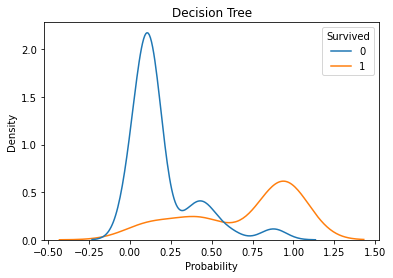

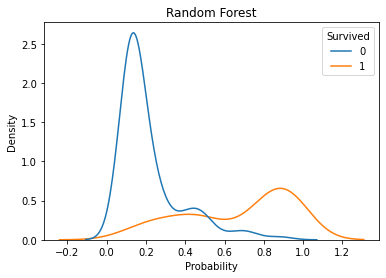

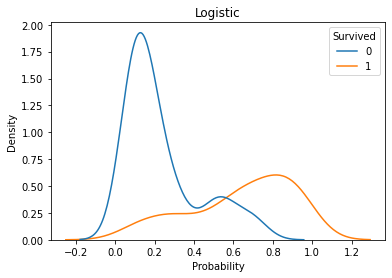

In [36]:
kdedata_dt = pd.concat([pd.DataFrame(tree.predict_proba(X_test)[:,1], columns = ['Probability']),
                            pd.DataFrame(y_test, columns = ['Survived']).reset_index() ], axis = 1)
kdedata_lr = pd.concat([pd.DataFrame(logit_fit.predict(X_test), columns = ['Probability']),
                            pd.DataFrame(y_test, columns = ['Survived']) ], axis = 1).reset_index() 
kdedata_rf = pd.concat([pd.DataFrame(rf.predict_proba(X_test)[:,1], columns = ['Probability']),
                            pd.DataFrame(y_test, columns = ['Survived']).reset_index() ], axis = 1)

plt.figure()
sns.kdeplot(data=kdedata_dt, x="Probability", hue = "Survived").set(title='Decision Tree')
plt.show()
sns.kdeplot(data=kdedata_rf, x="Probability", hue = "Survived").set(title='Random Forest')
plt.show()
sns.kdeplot(data=kdedata_lr, x="Probability", hue = "Survived").set(title='Logistic')
plt.show()

In an ideal world, we would like to see a clear seperation between the two density plots, with the deaths being clearly seperated to the left, and the survived population having a clear curve on the right. Although we can see some seperation, there is a large degree of overlap between the density plots. This indicates that that a cut-off for the predicted probability needs to be chosen carefully to maximize model performance (accuracy for e.g).

Although there are no negative predictions or above 1, the KDE plot shows this due to the Gaussian estimator. Hence the graph has been truncated to have only [0,1] as the limits of the x-axis.

## Calibration Curves

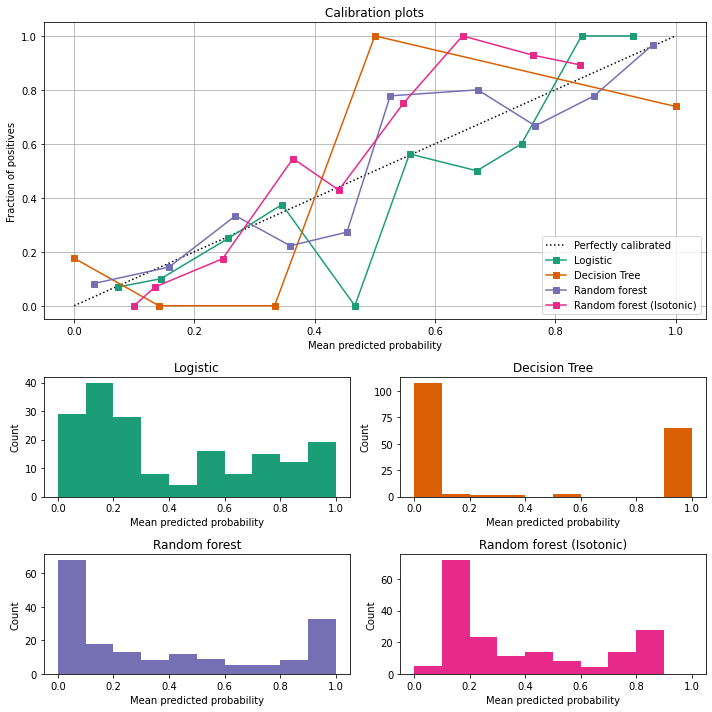

In [40]:
logit = LogisticRegression()
dt = DecisionTreeClassifier(random_state = 0)
rf = RandomForestClassifier(random_state = 0)
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, cv=3)

clf_list = [
    (logit, "Logistic"),
    (dt, "Decision Tree"),
    (rf, "Random forest"),
    (calibrated_rf, "Random forest (Isotonic)"),

]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Analysis of Calibration Curves

<a href="https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py" target="_blank">Source Code</a>

* Decision Tree: This model is very certain and doesn't have a large range of possible mean predicted probabilities. Predicted probabilities will be either 0 or 1, regardless of the bin being analysed in the calibration curve. The set at 0.6 is likely due to a mix of 0's and 1s in the predicted probabilities, with the average being 0.6.
* Logistic Regression: This model is generally overconfident (especially near 0), predicting higher probabilities than the binned set's fraction of positives. However, it follows the diagonal 'perfect' calibration curve better than the other models.
* Random Forest: This model is strongly overconfident for the majority of the graph (0-0.7), consistently predicting higher mean predicted probabilities than the binned set's fraction of positives. Additionally, it deviates quite far from the calibration curve. This indicates that the RF model might need tuning.

## Confusion Matrix

In [38]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, cv=3)

clf_list = [
    (lr, "Logistic"),
    (dt, "Decision Tree"),
    (rf, "Random forest"),
    (calibrated_rf, "Random forest (Isotonic)"),

]

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

[[93 17]
 [16 53]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.77      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

[[90 20]
 [20 49]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       110
           1       0.71      0.71      0.71        69

    accuracy                           0.78       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179

[[96 14]
 [19 50]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg     

* Generally, all models report approx. 80% accuracy. The highest accuracy is produced by logistic regression and the calibrated isotonic random forest. 
* The calibrated random forest only improves the confusion matrix by a few pairs, which is also reflected in the accuracy being only slightly more than random forest (84% vs. 82%)
* The sensitivity of all models is generally poorer for cases where the test case is a surviving passenger, hovering around 70-75%. This means that the probability of a model correctly selecting an alive passenger is ~ 75%. It's easier for a model to correctly identify dead passengers, with specificity being around 85-90%.

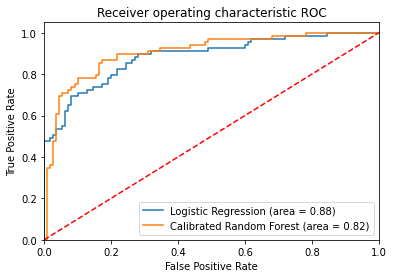

In [42]:
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, cv=3).fit(X_train, y_train)
y_pred = calibrated_rf.predict(X_test)

calibrated_rf_roc_auc = roc_auc_score(y_test, calibrated_rf.predict(X_test))
calibrated_rf_fpr, calibrated_rf_tpr, calibrated_rfthresholds = roc_curve(y_test, calibrated_rf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(calibrated_rf_fpr, calibrated_rf_tpr, label='Calibrated Random Forest (area = %0.2f)' % calibrated_rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

## ROC Curve

* The highest AUC (Area under the curve) is logistic regression. This is the sum of the performance across all classification thresholds. The highest AUC reported is by Logistic Regression.
* The diagonal line represents a cut-off of 0.5 (random guessing). We can see generally that all models perform much better than random guessing. 
* Random forest tends to minimize the FPR, while maximizing TPR at earlier cutoffs. However, the performance of the model eventually falls off, and logistic regression performs better overall across all thresholds. 
* The calibrated random forest is a decent compromise between randm forest and logistic regression. A smoother ROC indicates a smooth change of FPR/TPR across thresholds, which makes the model more reliable than abrupt spikes like we see in random forest.

## Assessing Performance

* The performance of the random forest after calibration is the best model thus far. The calibration curve is much better than the logistic regression following the diagonal line. 
* The random forest after calibration has very good specificity (identifying deaths correctly) of 0.95, whereas recall is only 0.68 (identifying alive correctly).
* Final Calibrated Random Forest metrics:
    * Accuracy: 0.85
    * Specificity: 0.95
    * Sensitivity: 0.68